02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [1]:
%pip install pandas
%pip install sqlalchemy
%pip install scikit-learn
%pip install imblearn
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 330.3 kB/s eta 0:06:19
   ---------------------------------------- 0.1/124.9 MB 1.1 MB/s eta 0:01:58
   ---------------------------------------- 0.4/124.9 MB 2.3 MB/s eta 0:00:56
   ---------------------------------------- 0.7/124.9 MB 3.2 MB/s eta 0:00:40
   ---------------------------------------- 1.1/124.9 MB 4.3 MB/s eta 0:00:29
    --------------------------------------- 1.8/124.9 MB 5.6 MB/s eta 0:00:23
    --------------------------------------- 2.3/124.9 MB 6.3 MB/s eta 0:00:20
    --------------------------------------- 2.5/124.9 MB 6.4 MB/s eta 0:00:20
    --------------------------------------- 2.9/124.9 MB 6.5 MB/s eta 0:00:19
   - ---------------

In [2]:
import warnings
import time
import pickle
import xgboost as xgb
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [5]:
# データの読み込み
train = pd.read_csv('C:/Users/momoka.miyaguchi.kd/OneDrive - AMBL株式会社/Python研修/kaggle/AnalyticalPipeline/momoka/data/processed/processed20240621_2_train.csv')
test = pd.read_csv('../data/raw/test.csv')
# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [10]:
# xgboostのパラメータ
param = {'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 12,
    
    'min_child_weight': 140,  # min_data_in_leafに相当
    'subsample': 0.7083,  # bagging_fractionに相当
    'colsample_bytree': 0.7522,  # feature_fractionに相当
    'lambda': 0.2634,  # lambda_l1に相当
    'seed': 133,
    'verbosity': 1
  }  # XGBoostのverbosityは0から3の範囲}

In [4]:
# param = {
#     'objective': ['reg:squarederror'],
#     'eval_metric': ['rmse'],
#     'learning_rate': [0.005, 0.01, 0.012],
#     'max_depth': [6, 9, 12],
#     'min_child_weight': [110, 140, 170],
#     'subsample': [0.7],
#     'colsample_bytree': [0.7522],
#     'n_estimators': [400],
#     'lambda': [0.2634],  # lambda_l1に相当
#     'seed': [133],
#     'verbosity': [1]
# }

In [7]:
# 特徴量の情報
train['first_active_month'] = pd.to_datetime(train['first_active_month'])
train['card_id'] = train['card_id'].astype('category')
test['first_active_month'] = pd.to_datetime(test['first_active_month'])
test['card_id'] = test['card_id'].astype('category')

train.drop(columns=['first_active_month'], inplace=True)
test.drop(columns=['first_active_month'], inplace=True)

# card_idをカテゴリ型に変換
train['card_id'] = train['card_id'].astype('category').cat.codes
test['card_id'] = test['card_id'].astype('category').cat.codes
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [8]:
def reduce_mem_usage(df, verbose=True):
    """
    データフレームのメモリ使用量を減らす。

    Parameters
    ----------
    df : pd.DataFrame
        メモリ使用量を削減したいデータフレーム。
    verbose : bool, optional
        メモリ使用量の削減結果を出力するかどうか（デフォルトは True）。

    Returns
    -------
    pd.DataFrame
        メモリ使用量が削減されたデータフレーム。
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train.shape

(201917, 162)

In [7]:
train = reduce_mem_usage(train)
max_features =   135# 例として、最大3つの特徴量の組み合わせを生成する場合
from itertools import combinations
# 列名の組み合わせを逐次的に生成し、それぞれの組み合わせに対して処理を行う例
for combo in combinations(train.columns, max_features):
    print(combo)

In [17]:
# train = reduce_mem_usage(train)
# max_features =   150# 例として、最大3つの特徴量の組み合わせを生成する場合
# from itertools import combinations
# for combo in combinations(train.columns, max_features):
#     features = list(combo)

#     folds = KFold(n_splits=5, shuffle=True, random_state=15)
#     oof = np.zeros(len(train))
#     # xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
#     # grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param, cv=folds,
#     #                            scoring='neg_mean_squared_error', verbose=2)
#     # grid_search.fit(train[features], target)

#     # best_params = grid_search.best_params_
#     # print("Best parameters found for combo {}: {}".format(combo, best_params))
#     # best_score_combo = np.sqrt(-grid_search.best_score_)
#     # print("Best RMSE score for combo {}: {}".format(combo, best_score_combo))

#     for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
#         print("fold n°{}".format(fold_))
#         trn_data = xgb.DMatrix(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
#         val_data = xgb.DMatrix(train.iloc[val_idx][features], label=target.iloc[val_idx])

#         clf = xgb.train(params=best_params,
#                         dtrain=trn_data,
#                         num_boost_round=10000,
#                         evals=[(val_data, 'val')],
#                         early_stopping_rounds=200,
#                         verbose_eval=100)

#         best_iteration = clf.best_iteration if hasattr(clf, 'best_iteration') else None

#         if best_iteration is not None:
#             oof[val_idx] = clf.predict(xgb.DMatrix(train.iloc[val_idx][features]), iteration_range=(0, best_iteration))
#         else:
#             oof[val_idx] = clf.predict(xgb.DMatrix(train.iloc[val_idx][features]))

#     rmse_score = mean_squared_error(target, oof) ** 0.5
#     print("CV score for combo {}: {:<8.5f}".format(combo, rmse_score))

#     if rmse_score < best_score:
#         best_score = rmse_score
#         best_features = features

# print("Best features: ", best_features)
# print("Best CV score: {:<8.5f}".format(best_score))

In [14]:
train = reduce_mem_usage(train)

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

# xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param, cv=folds,
#                            scoring='neg_mean_squared_error', verbose=2)
# grid_search.fit(train, target)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)
# best_score = np.sqrt(-grid_search.best_score_)
# print("Best RMSE score: ", best_score)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = xgb.DMatrix(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(train.iloc[val_idx][features], label=target.iloc[val_idx])

    clf = xgb.train(params=param,
                    dtrain=trn_data,
                    num_boost_round=10000,
                    evals=[(val_data, 'val')],
                    early_stopping_rounds=200,
                    verbose_eval=100)

    # ntree_limitは、early_stopping_roundsが適用された場合、ベストなイテレーション数に設定します。
    best_iteration = clf.best_iteration if hasattr(clf, 'best_iteration') else None

    if best_iteration is not None:
        oof[val_idx] = clf.predict(xgb.DMatrix(train.iloc[val_idx][features]), iteration_range=(0, best_iteration))
    else:
        oof[val_idx] = clf.predict(xgb.DMatrix(train.iloc[val_idx][features]))

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.get_score(importance_type='weight').values()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    with open(f'C:/Users/momoka.miyaguchi.kd/OneDrive - AMBL株式会社/Python研修/kaggle/AnalyticalPipeline/src/models/xgb_model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

Mem. usage decreased to 70.86 Mb (0.0% reduction)
fold n°0


c:\Users\momoka.miyaguchi.kd\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:36:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	val-rmse:3.88043
[100]	val-rmse:3.72225
[200]	val-rmse:3.68977
[300]	val-rmse:3.67984
[400]	val-rmse:3.67575
[500]	val-rmse:3.67437
[600]	val-rmse:3.67399
[700]	val-rmse:3.67438
[779]	val-rmse:3.67403
fold n°1


c:\Users\momoka.miyaguchi.kd\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	val-rmse:3.80231
[100]	val-rmse:3.65492
[200]	val-rmse:3.62537
[300]	val-rmse:3.61774
[400]	val-rmse:3.61515
[500]	val-rmse:3.61428
[600]	val-rmse:3.61500
[673]	val-rmse:3.61517
fold n°2


c:\Users\momoka.miyaguchi.kd\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:38:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	val-rmse:3.77710
[100]	val-rmse:3.63355
[200]	val-rmse:3.60830
[300]	val-rmse:3.60003
[400]	val-rmse:3.59765
[500]	val-rmse:3.59666
[600]	val-rmse:3.59708
[644]	val-rmse:3.59749
fold n°3


c:\Users\momoka.miyaguchi.kd\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	val-rmse:3.98298
[100]	val-rmse:3.82572
[200]	val-rmse:3.79230
[300]	val-rmse:3.78334
[400]	val-rmse:3.78010
[500]	val-rmse:3.77948
[600]	val-rmse:3.77923
[700]	val-rmse:3.77976
[753]	val-rmse:3.77974
fold n°4


c:\Users\momoka.miyaguchi.kd\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:40:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	val-rmse:3.79021
[100]	val-rmse:3.64640
[200]	val-rmse:3.62073
[300]	val-rmse:3.61519
[400]	val-rmse:3.61466
[500]	val-rmse:3.61504
[600]	val-rmse:3.61623
[610]	val-rmse:3.61652
CV score: 3.65620 


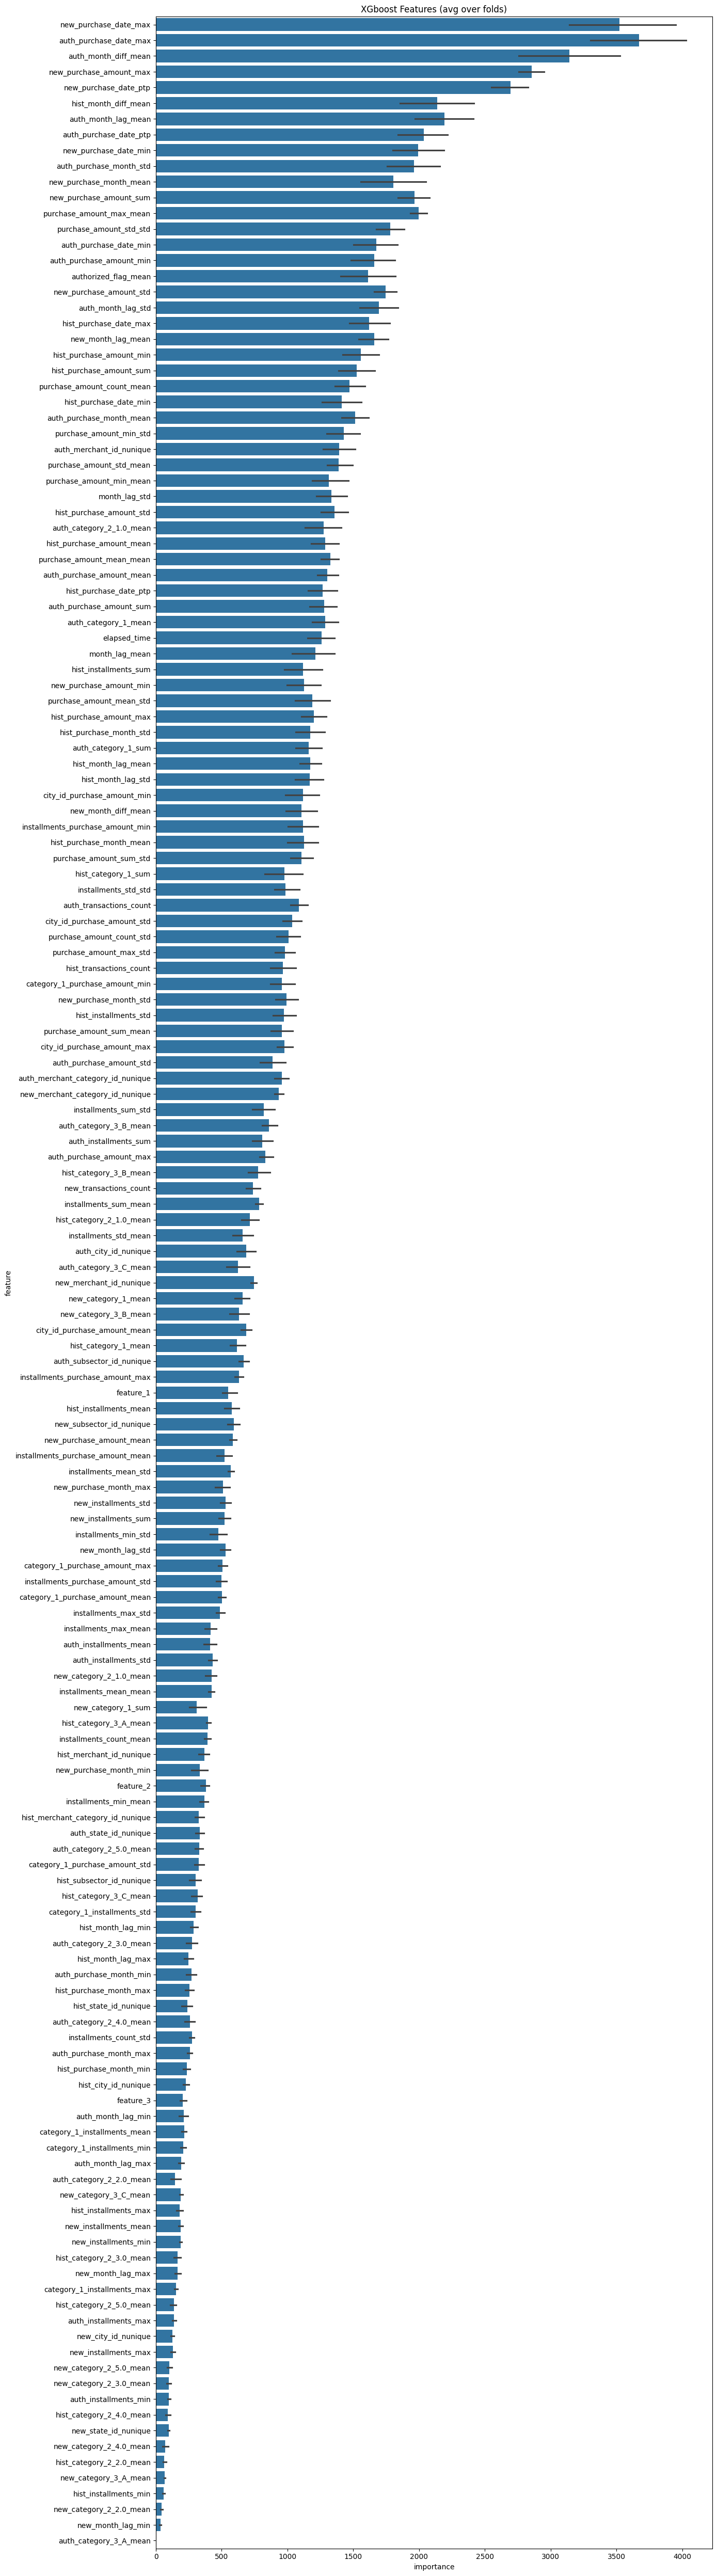

In [9]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('XGboost Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')